In [1]:
import torch
import torchvision
import os
from torchvision import transforms
import numpy as np

In [2]:
ts = transforms.Compose([
    transforms.Grayscale(1),
    transforms.RandomAffine(0, translate=(.1, .1)),
    transforms.ToTensor(),
    transforms.Normalize((0,),(1,))
])
data = torchvision.datasets.CIFAR10(root=os.path.join("../drive", "My Drive", "data"), train=True, download=True, transform=ts)

Files already downloaded and verified


In [3]:
def rescale(x, low, high):
    assert(low < high), "[rescale] low={0} must be smaller than high={1}".format(
        low, high)
    old_width = torch.max(x)-torch.min(x)
    old_center = torch.min(x) + (old_width / 2.)
    new_width = float(high-low)
    new_center = low + (new_width / 2.)
    # shift everything back to zero:
    x = x - old_center
    # rescale to correct width:
    x = x * (new_width / old_width)
    # shift everything to the new center:
    x = x + new_center
    # return:
    return x

In [4]:
def zca_matrix(data_tensor):
    """
    Helper function: compute ZCA whitening matrix across a dataset ~ (N, C, H, W).
    """
    # flatten dataset:
    X = data_tensor.view(data_tensor.shape[0], -1)

    # zero-center the matrix:
    X = rescale(X, -1., 1.)

    # compute covariances:
    cov = torch.t(X) @ X

    # Singular Value Decomposition
    # S :: Sigma
    # compute ZCA(X) == U @ (diag(1/S)) @ torch.t(V) where U, S, V = SVD(cov):
    U, S, V = torch.svd(cov)
    #epsilon = 2.220446049250313e-16 
    return (U @ torch.diag(torch.reciprocal(S)) @ torch.t(V))

In [54]:
# concatenated data has shape of [50000, 32, 32]
whiten_matrix = zca_matrix(torch.cat([x for (x, _) in data], dim=0))
print(whiten_matrix.shape)
print(whiten_matrix)

torch.Size([1024, 1024])
tensor([[ 1.0866e-03, -7.4832e-04,  4.3890e-05,  ...,  9.6689e-06,
         -6.3346e-06, -4.3143e-05],
        [-7.4832e-04,  1.4914e-03, -8.0191e-04,  ..., -1.7067e-06,
          3.9818e-06, -2.5919e-06],
        [ 4.4425e-05, -8.0261e-04,  1.6828e-03,  ..., -1.1523e-05,
          8.2365e-06, -5.6687e-06],
        ...,
        [ 9.9581e-06, -1.8080e-06, -1.1424e-05,  ...,  1.9585e-03,
         -9.4028e-04,  7.9751e-05],
        [-6.5207e-06,  4.0621e-06,  8.2381e-06,  ..., -9.4011e-04,
          1.7438e-03, -8.9274e-04],
        [-4.3078e-05, -2.5847e-06, -5.7174e-06,  ...,  7.9561e-05,
         -8.9268e-04,  1.2419e-03]])


In [6]:
torch.save(whiten_matrix, os.path.join("../drive", "My Drive", "zca_matrix.pt"))

In [62]:
def mean_vector(data_tensor):
    X = data_tensor.view(data_tensor.shape[0], -1)
    X = torch.mean(X, 0)
    return X

In [63]:
mean = mean_vector(torch.cat([x for (x, _) in data], dim=0))
print(mean.shape)
print(mean)

torch.Size([1024])
tensor([0.1756, 0.2235, 0.2714,  ..., 0.2455, 0.2030, 0.1593])


In [ ]:
torch.save(mean, os.path.join("../drive", "My Drive", "mean.pt"))

In [9]:
ts_w = transforms.Compose([
    ts,
    transforms.LinearTransformation(whiten_matrix, mean)
])
data_w = torchvision.datasets.CIFAR10(root=os.path.join("../drive", "My Drive", "data"), train=True, download=True, transform=ts_w)

Files already downloaded and verified


In [10]:
import matplotlib.pyplot as plt

In [50]:
grid = torchvision.utils.make_grid([x for (x,_) in data][:16], nrow=4, padding=2)

In [67]:
grid_w = torchvision.utils.make_grid([x*1024 for (x,_) in data_w][:16], nrow=4, padding=2)

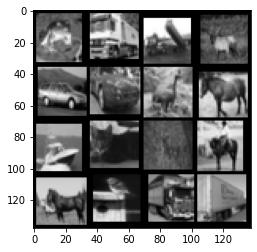

In [68]:
plt.imshow(grid.permute(1,2,0), cmap="gray")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


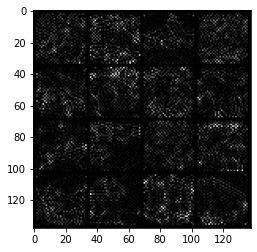

In [69]:
plt.imshow((grid_w.permute(1,2,0)), cmap="binary")

In [47]:
 img_i= 2

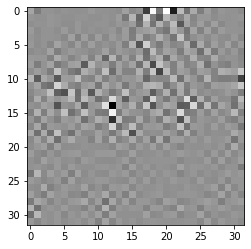

In [48]:
plt.imshow(data_w[img_i][0].reshape(32,32), cmap="binary")

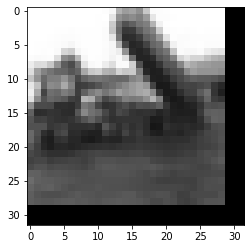

In [49]:
plt.imshow(data[img_i][0].reshape(32,32), cmap="gray")